In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv("MHPIquarter.csv",header = 0, index_col = 0)
data.tail()

,House Price Index
Date,
01/10/2021,205.0
01/01/2022,205.9
01/04/2022,207.8
01/07/2022,212.4
01/10/2022,213.0


In [2]:
data.describe()

,House Price Index
count,52.000000
mean,166.405769
std,36.128417
min,97.200000
25%,136.850000
50%,176.450000
75%,198.975000
max,213.000000


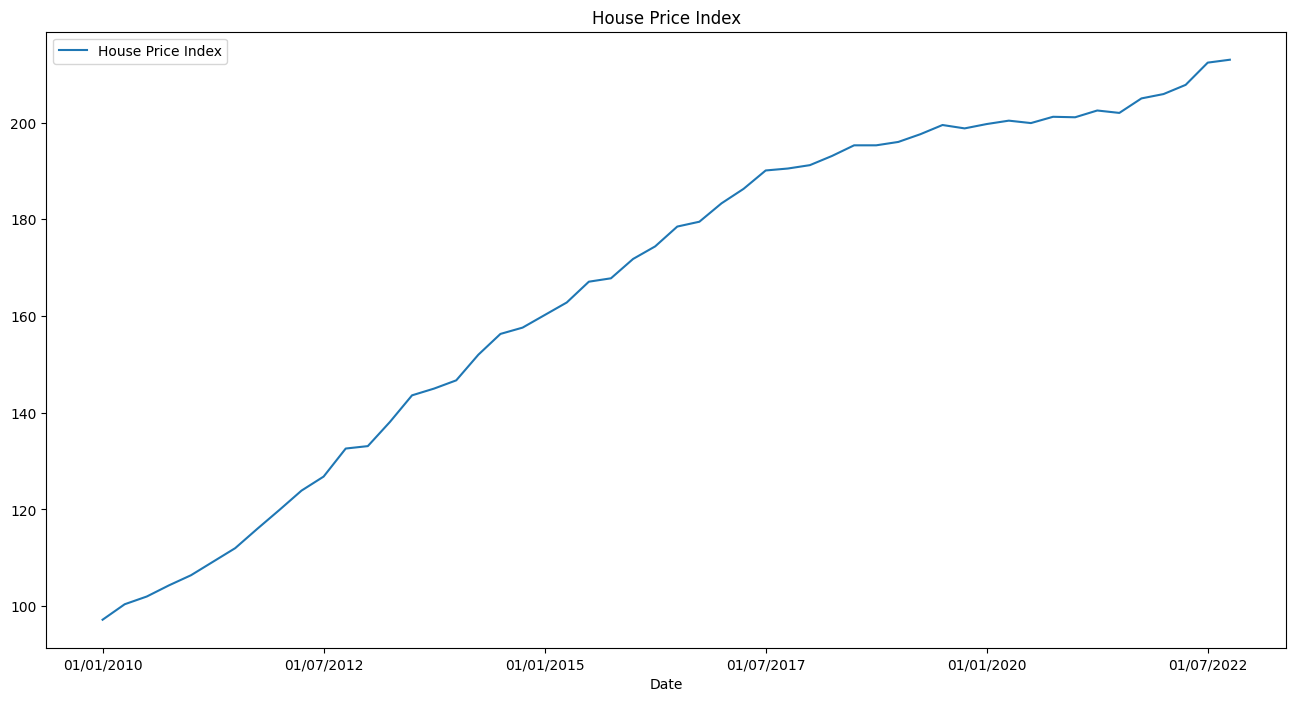

In [3]:
#plot the time series data
from matplotlib import pyplot
data.plot(figsize = (16, 8), title='House Price Index', fontsize=10)
pyplot.show()

In [4]:
#Split data training (in-sample) & testing (out-sample)
training = data[0:42] # 90 in-sample data
testing = data[42:] #10 out-sample data

In [5]:
testing

,House Price Index
Date,
01/07/2020,199.9
01/10/2020,201.2
01/01/2021,201.1
01/04/2021,202.5
01/07/2021,202.0
01/10/2021,205.0
01/01/2022,205.9
01/04/2022,207.8
01/07/2022,212.4


In [6]:
#normality for in-sample data
from scipy.stats import shapiro 
shapiro(training)

ShapiroResult(statistic=0.9122216105461121, pvalue=0.0034128702245652676)

In [7]:
#skewness in-sample data
from scipy.stats import skew
skew(training)

array([-0.31304564])

In [8]:
#Box-cox transformation (check stationarity in variance)
Price = training["House Price Index"]
import scipy as sp
from scipy.stats import boxcox
Price, lam = boxcox(Price)
lam

1.6438587653199819

In [9]:
#transform data using power
import numpy as np
transform_training =np.sqrt(training) #transform training data
transform_testing = np.sqrt(testing) #transform testing data

In [10]:
#stationary test using ADF test (to check stationarity in mean)
from statsmodels.tsa.stattools import adfuller
print("p-value:", adfuller(transform_training.dropna())[1])

p-value: 0.018097081705869104


C:\Users\Asus\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


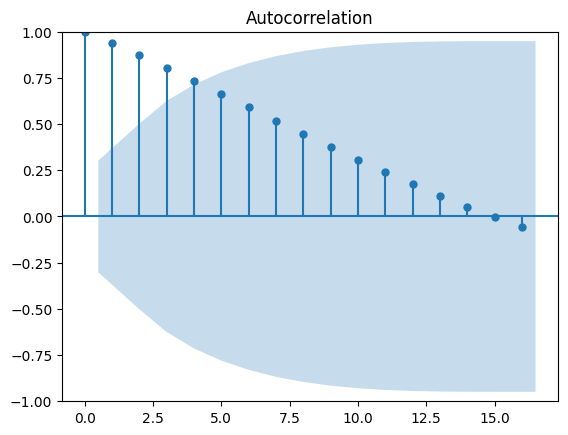

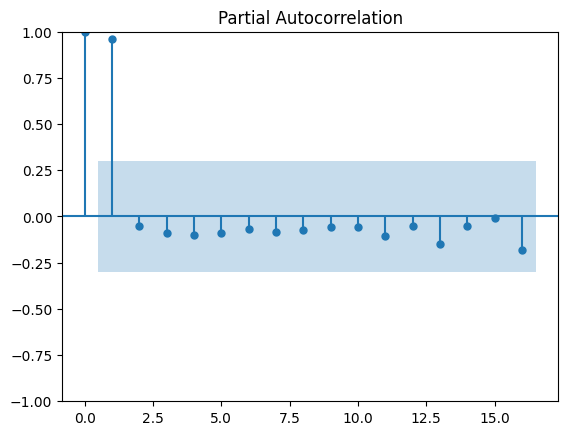

In [11]:
#stationarity test in mean using ACF & PACF plot 
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(transform_training,lags = 16),plot_pacf(transform_training, lags = 16) #determine lag using kmax=10*log (10)T=21
pyplot.show()

In [12]:
from pmdarima.arima import auto_arima as ARIMA
model = ARIMA(y=transform_training, trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-108.758, Time=0.39 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-79.878, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-91.789, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-104.157, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-107.207, Time=0.10 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-105.562, Time=0.12 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-110.454, Time=0.17 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-112.226, Time=0.13 sec
 ARIMA(3,2,0)(0,0,0)[0]             : AIC=-114.223, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=-98.614, Time=0.04 sec
 ARIMA(4,2,0)(0,0,0)[0]             : AIC=-112.226, Time=0.08 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=-110.485, Time=0.17 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-113.384, Time=0.09 sec

Best model:  ARIMA(3,2,0)(0,0,0)[0]          
Total fit time: 1.560 seconds


In [13]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   42
Model:               SARIMAX(3, 2, 0)   Log Likelihood                  61.112
Date:                Sun, 25 Jun 2023   AIC                           -114.223
Time:                        14:27:46   BIC                           -107.468
Sample:                             0   HQIC                          -111.781
                                 - 42                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0618      0.110     -9.616      0.000      -1.278      -0.845
ar.L2         -0.9114      0.153     -5.965      0.000      -1.211      -0.612
ar.L3         -0.5879      0.147     -4.000      0.0

In [14]:
import statsmodels as sm
model_test = sm.api.tsa.ARIMA(transform_training.values,order=(3, 2, 0),trend='n')
model_test = model_test.fit()
model_test

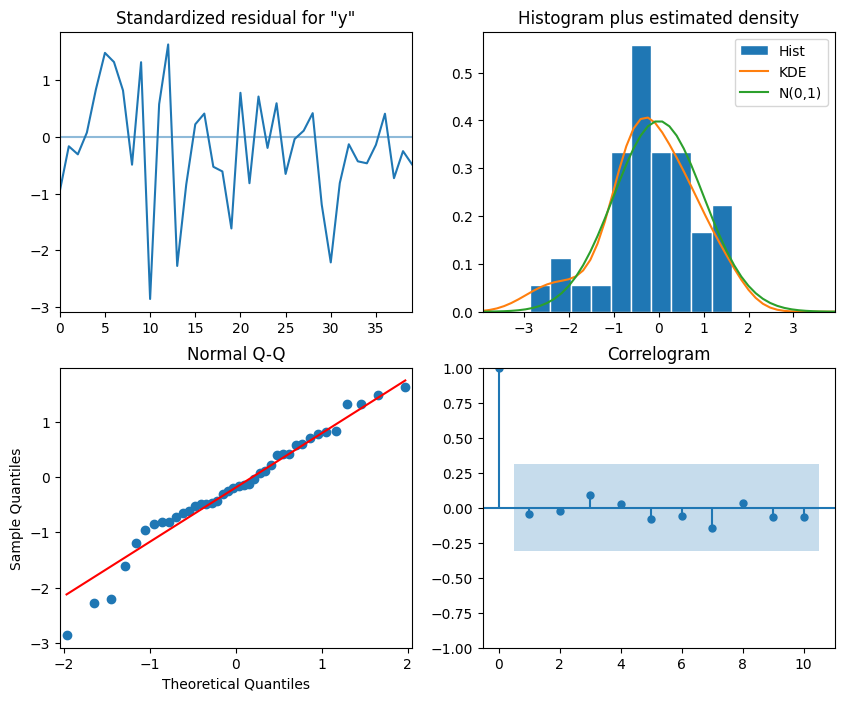

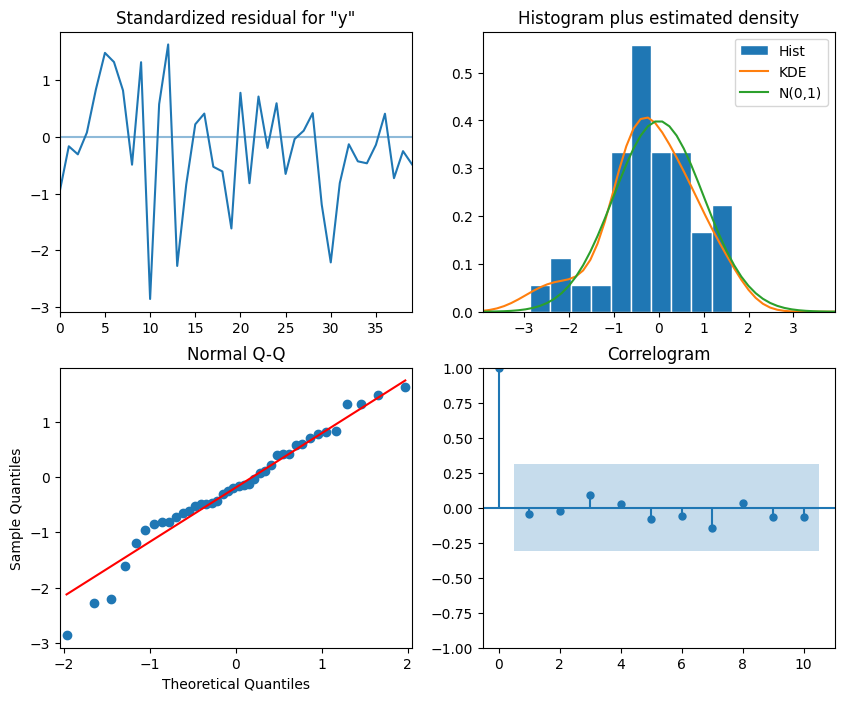

In [15]:
model_test.plot_diagnostics(figsize=(10,8))

### Forecasting

In [16]:
# initialize variables for storing predictions and actual values
predictions = []
training = transform_training
acm_model = model_test
# iterate over each time step in the testing data
for i,_ in enumerate(transform_testing.values):
    # make one-step ahead forecast
    yhat = acm_model.forecast()
    # store prediction and actual value
    predictions.append(yhat)
    
    # add actual value to training data
    training = pd.concat((training, transform_testing.iloc[[i]][['House Price Index']]))
    
    # retrain model on updated training data
    acm_model = sm.api.tsa.ARIMA(training.values, order=(3, 2, 0), trend='n')
    acm_model = acm_model.fit()
transform_testing[['Forecast']] = predictions

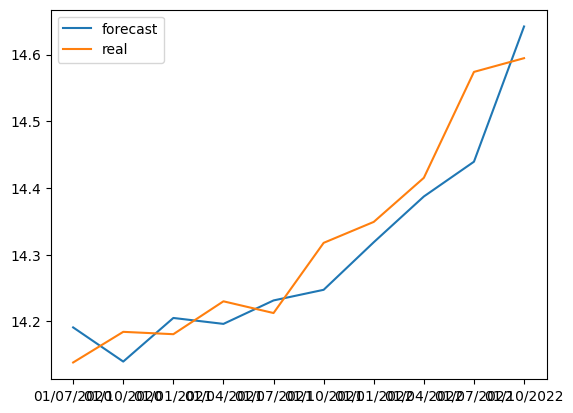

In [17]:
import matplotlib.pyplot as plt
plt.plot(transform_testing['Forecast'] ,label='forecast')
plt.plot(transform_testing['House Price Index'],label='real')
plt.legend()

In [18]:
transform_testing['House Price Index'],transform_testing['Forecast']

(Date
 01/07/2020    14.138600
 01/10/2020    14.184499
 01/01/2021    14.180973
 01/04/2021    14.230249
 01/07/2021    14.212670
 01/10/2021    14.317821
 01/01/2022    14.349216
 01/04/2022    14.415270
 01/07/2022    14.573949
 01/10/2022    14.594520
 Name: House Price Index, dtype: float64,
 Date
 01/07/2020    14.191149
 01/10/2020    14.139953
 01/01/2021    14.205298
 01/04/2021    14.196417
 01/07/2021    14.231556
 01/10/2021    14.247493
 01/01/2022    14.318738
 01/04/2022    14.387288
 01/07/2022    14.439402
 01/10/2022    14.642012
 Name: Forecast, dtype: float64)

In [19]:
transform_testing.loc[:,'Forecast'] ** 2

Date
01/07/2020    201.388718
01/10/2020    199.938268
01/01/2021    201.790493
01/04/2021    201.538262
01/07/2021    202.537182
01/10/2021    202.991055
01/01/2022    205.026271
01/04/2022    206.994053
01/07/2022    208.496322
01/10/2022    214.388515
Name: Forecast, dtype: float64

In [20]:
testing[['Forecast']] = transform_testing[['Forecast']] ** 2

C:\Users\Asus\AppData\Local\Temp\ipykernel_20016\1332102646.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing[['Forecast']] = transform_testing[['Forecast']] ** 2


In [21]:
testing

,House Price Index,Forecast
Date,,
01/07/2020,199.9,201.388718
01/10/2020,201.2,199.938268
01/01/2021,201.1,201.790493
01/04/2021,202.5,201.538262
01/07/2021,202.0,202.537182
01/10/2021,205.0,202.991055
01/01/2022,205.9,205.026271
01/04/2022,207.8,206.994053
01/07/2022,212.4,208.496322


In [23]:
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Calculate the mae, mse ,rmse
mae = mean_absolute_error(testing['House Price Index'], testing['Forecast'])
mse = mean_squared_error(testing['House Price Index'], testing['Forecast'])
rmse = np.sqrt(mean_squared_error(testing['House Price Index'], testing['Forecast']))
# Print the MSE
print('MSE:', mse)
print('RMSE:', rmse)
print('MAE:', mae)

MSE: 2.811402531476422
RMSE: 1.6767237493029143
MAE: 1.3920677908211474


In [24]:
futureforecast = acm_model.forecast(steps=32)**2 # note that the data is transformed

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv("HPI_arima_forecast_final.csv",header = 0, index_col = 0)
data.tail()

,House Price Index
Date,
01/10/2029,280.5
01/01/2030,283.0
01/04/2030,285.6
01/07/2030,288.2
01/10/2030,290.8


In [26]:
data.describe()

,House Price Index
count,84.000000
mean,199.101190
std,52.483105
min,97.200000
25%,162.150000
50%,200.150000
75%,239.075000
max,290.800000


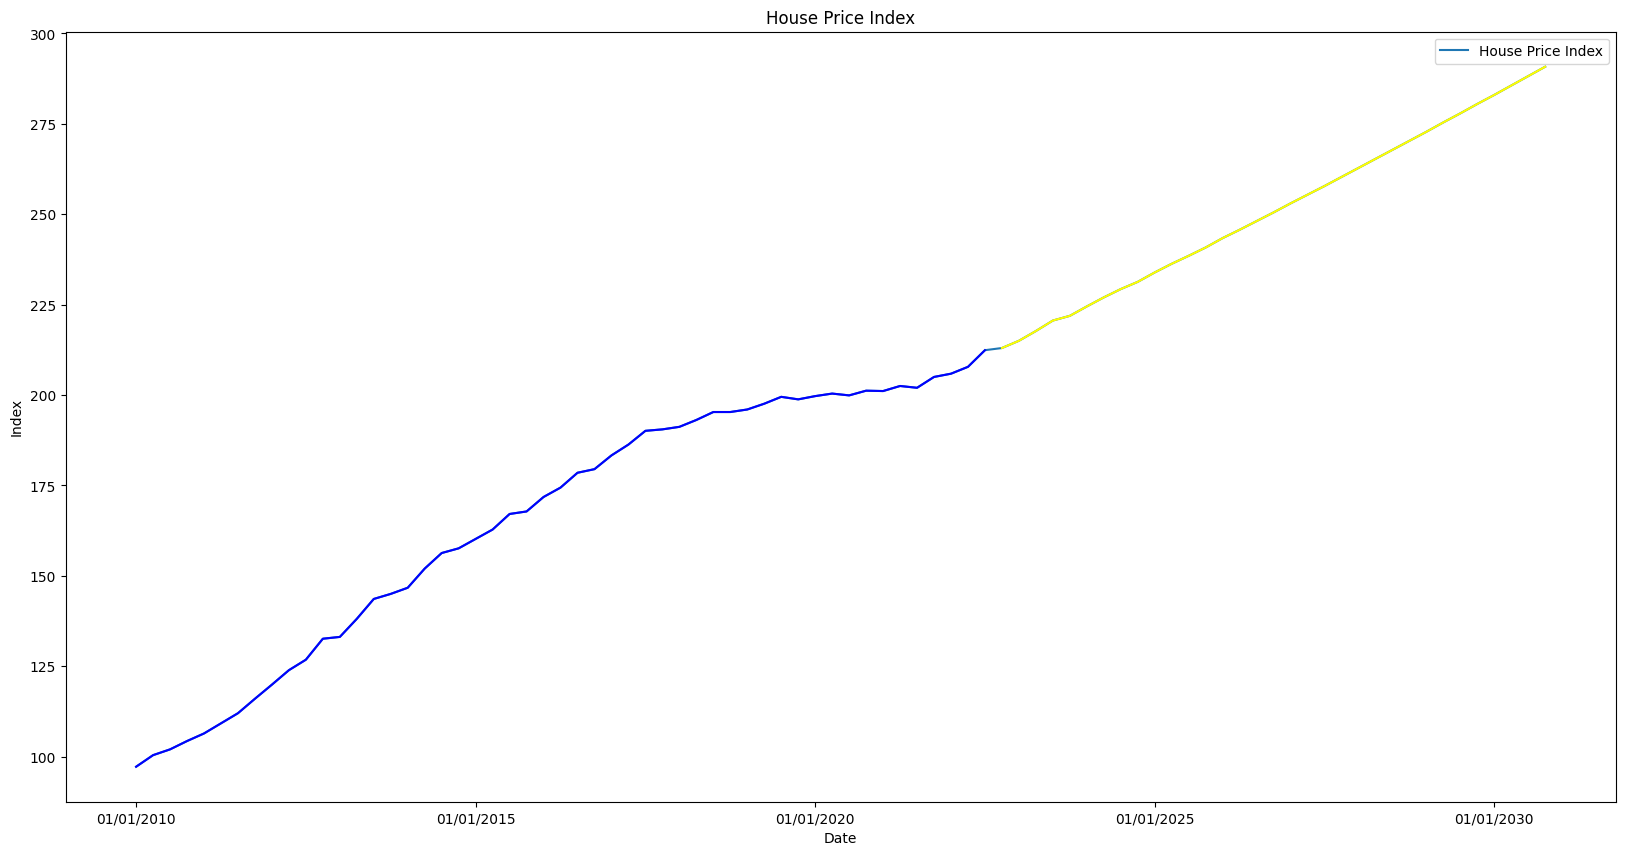

In [27]:
from matplotlib import pyplot as plt

# Plot the entire data
data.plot(figsize = (20, 10), title='House Price Index', fontsize=10)

# Define the start and end indices for the two segments
start_index = 51
end_index = 84

# Plot the first segment with a blue line
plt.plot(data.index[:start_index], data['House Price Index'][:start_index], color='blue')

# Plot the second segment with a yellow line
plt.plot(data.index[start_index:end_index+1], data['House Price Index'][start_index:end_index+1], color='yellow')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Index')

# Display the plot
plt.show()
